# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net
### Preprocessing

#### **Vorbereitung**

In [1]:
# import libraries
from uuid import uuid4
from random import randint
import os
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)
    
import src.preprocessing_v2 as pre
import src.data_loader_v2 as dl
import src.visualization as vis
import src.model_constructor as mc

In [2]:
# boolean values to control the program flow
TESTING: bool = True
DOWNLOAD: bool = False

# setup a single index for control of preprocessing steps
CONTROL_INDEX: int = randint(0,9)

In [3]:
# generate a unique identifier for this run
UUID: str = str(uuid4())

In [4]:
# setup system and check the number of cpu cores and gpus available
mc.system_setup()

Number of CPU cores:		12
Number of GPUs available:	0


#### **Laden der Datensätze**

In [5]:
if DOWNLOAD:
    
    # download full dataset from kaggle
    dl.fetch_kaggle_dataset(dl.DATASET_ADDRESS)

In [6]:
if not TESTING:
    
    # load data from folder and split in training and evaluation data
    data_path = Path().cwd() / "data" / "raw"
    development_data, evaluation_data = dl.load_all_datasets(data_path)
    all_datasets = development_data + evaluation_data

else:

    # program testing set
    test = dl.load_dataset(Path("./data/raw/0D.csv"))

0D.csv successfully loaded.


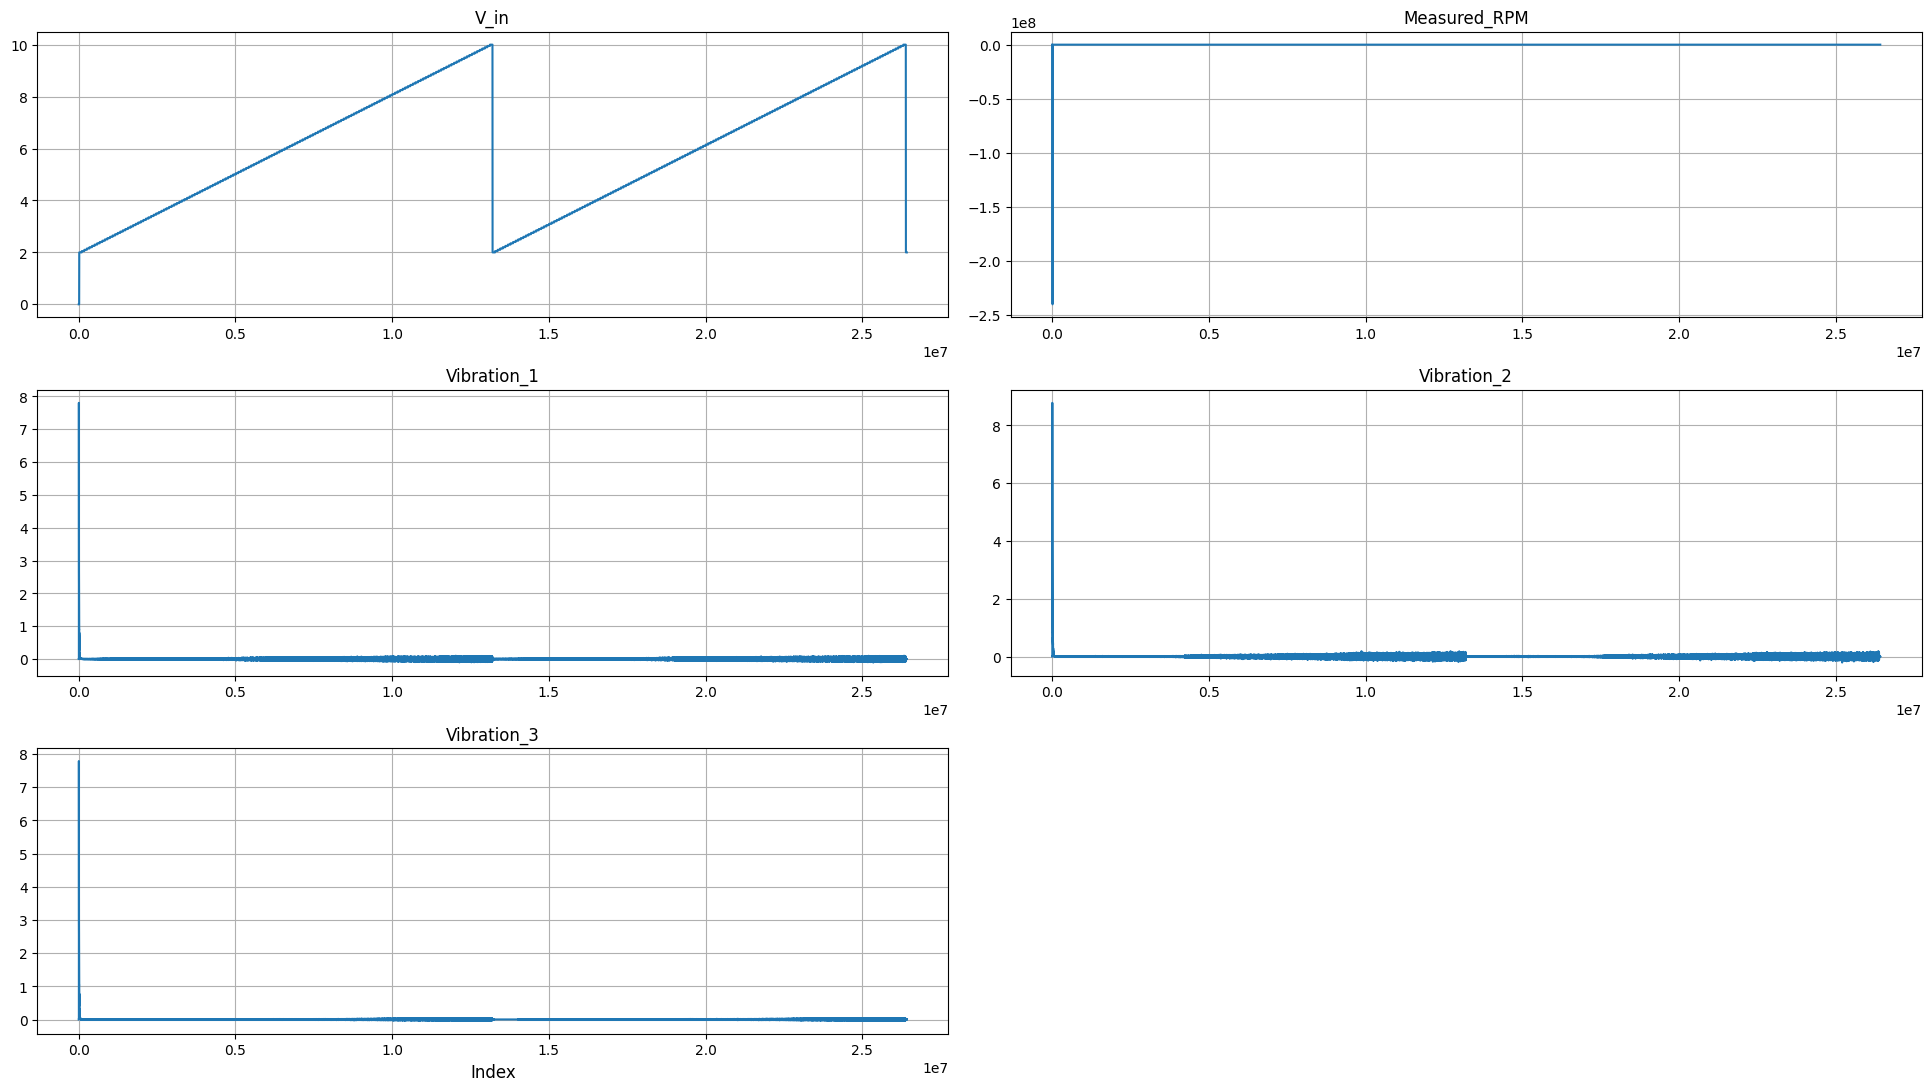

In [7]:
if not TESTING:
    
    # visualize one random dataset for data validation
    vis.plot_columns_as_subplots(all_datasets[CONTROL_INDEX], all_datasets[CONTROL_INDEX].columns)

else:

    # visualize the program testing set
    vis.plot_columns_as_subplots(test, test.columns)

#### **Preprocessing**

##### **Bereinigung der Daten**
Jeder Datensatz beginnt mit negativen Spitzen in den V_in und den Measured_RPM. Tresholding einer der beiden Messreihen entfernt diese Fehler im jeweiligen Datensatz. Durch Anpassung der Indizes beginnt jeder Datensatz mit Index 0.



# ACHTUNG
- Split in zwei Anläufe fehlt!
- RobustScaler Daten kontrollieren. Die Werte sollen in einer Range +-1 liegen!

In [ ]:
if not TESTING:

    for index, dataset in enumerate(all_datasets):
        pre.apply_threshold(dataset, threshold=0, column="V_in", mode="le", reset_index=True)

        
else:
    
    pre.apply_threshold(test, threshold=0, column="V_in", mode="le", reset_index=True)
    test_measurement_cycles = pre.split_by_gradient_direction(test, column="V_in")

12288 rows discarded.


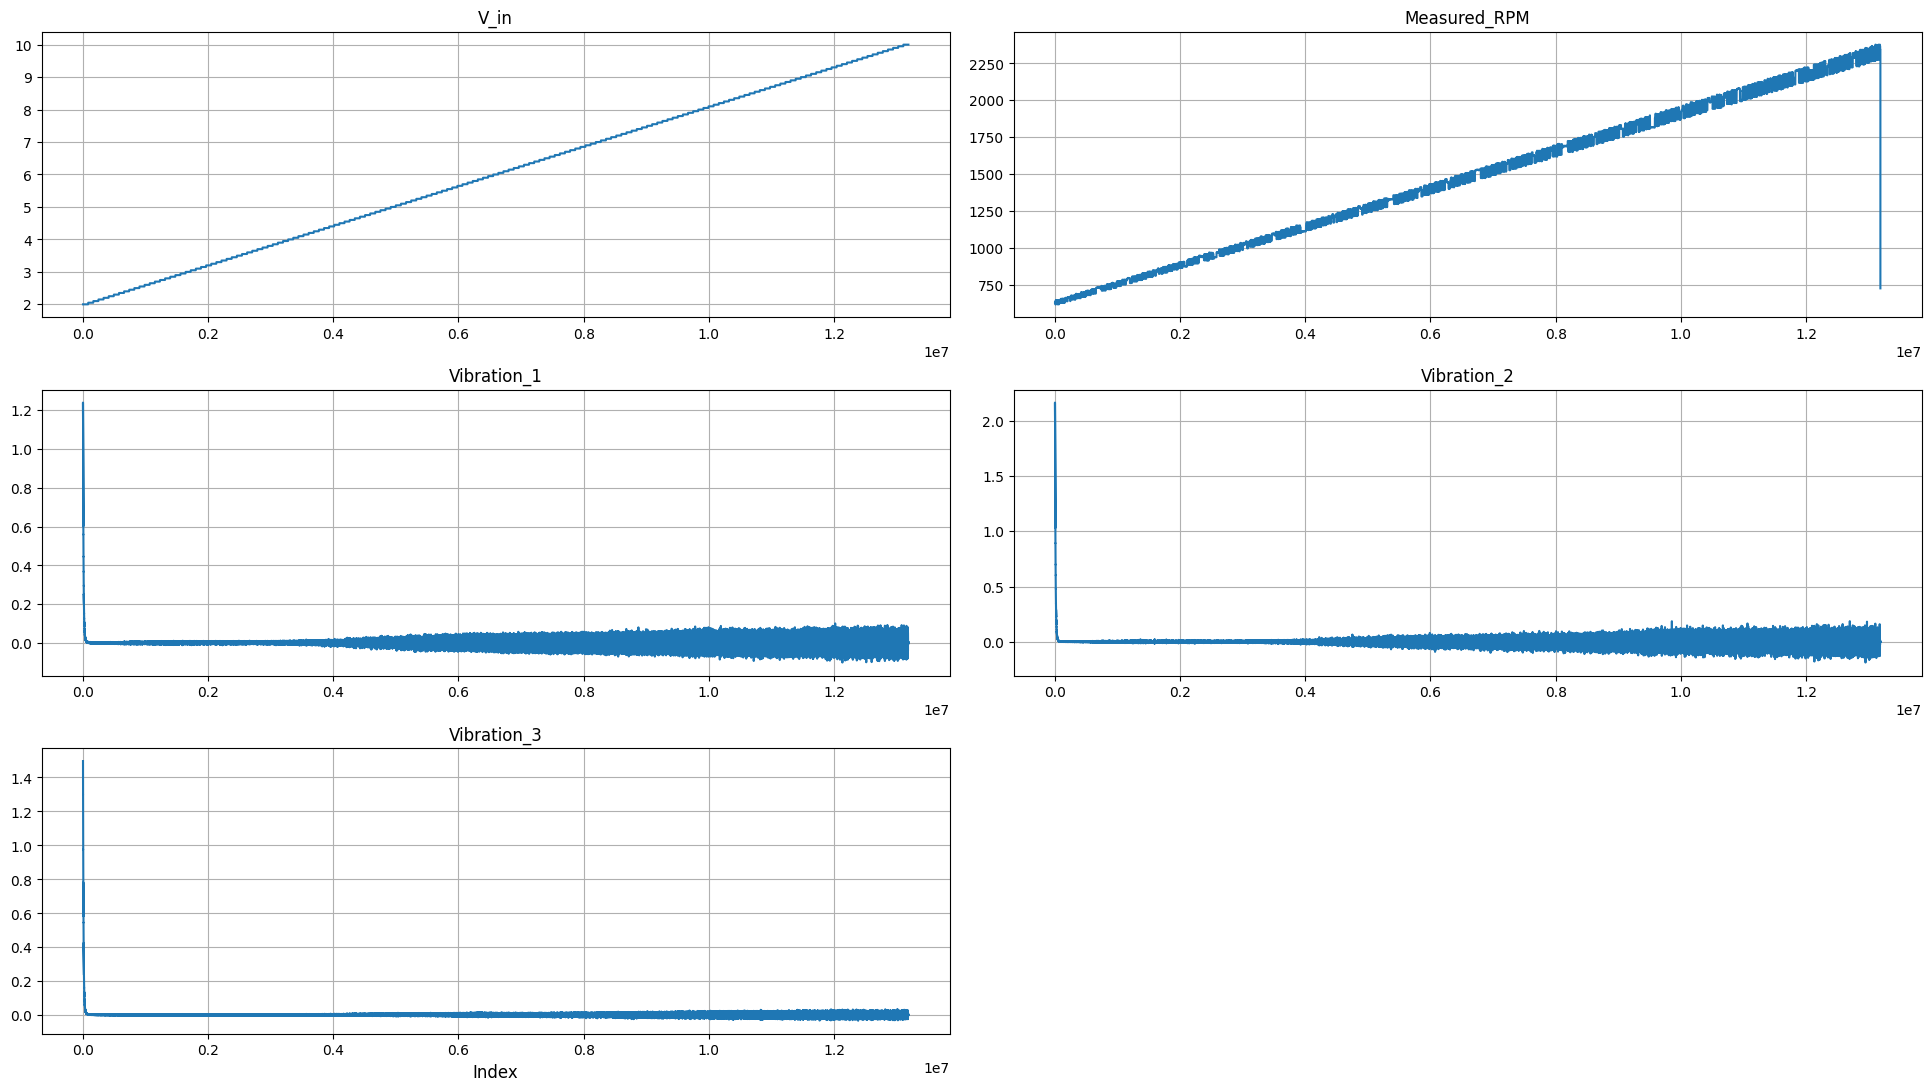

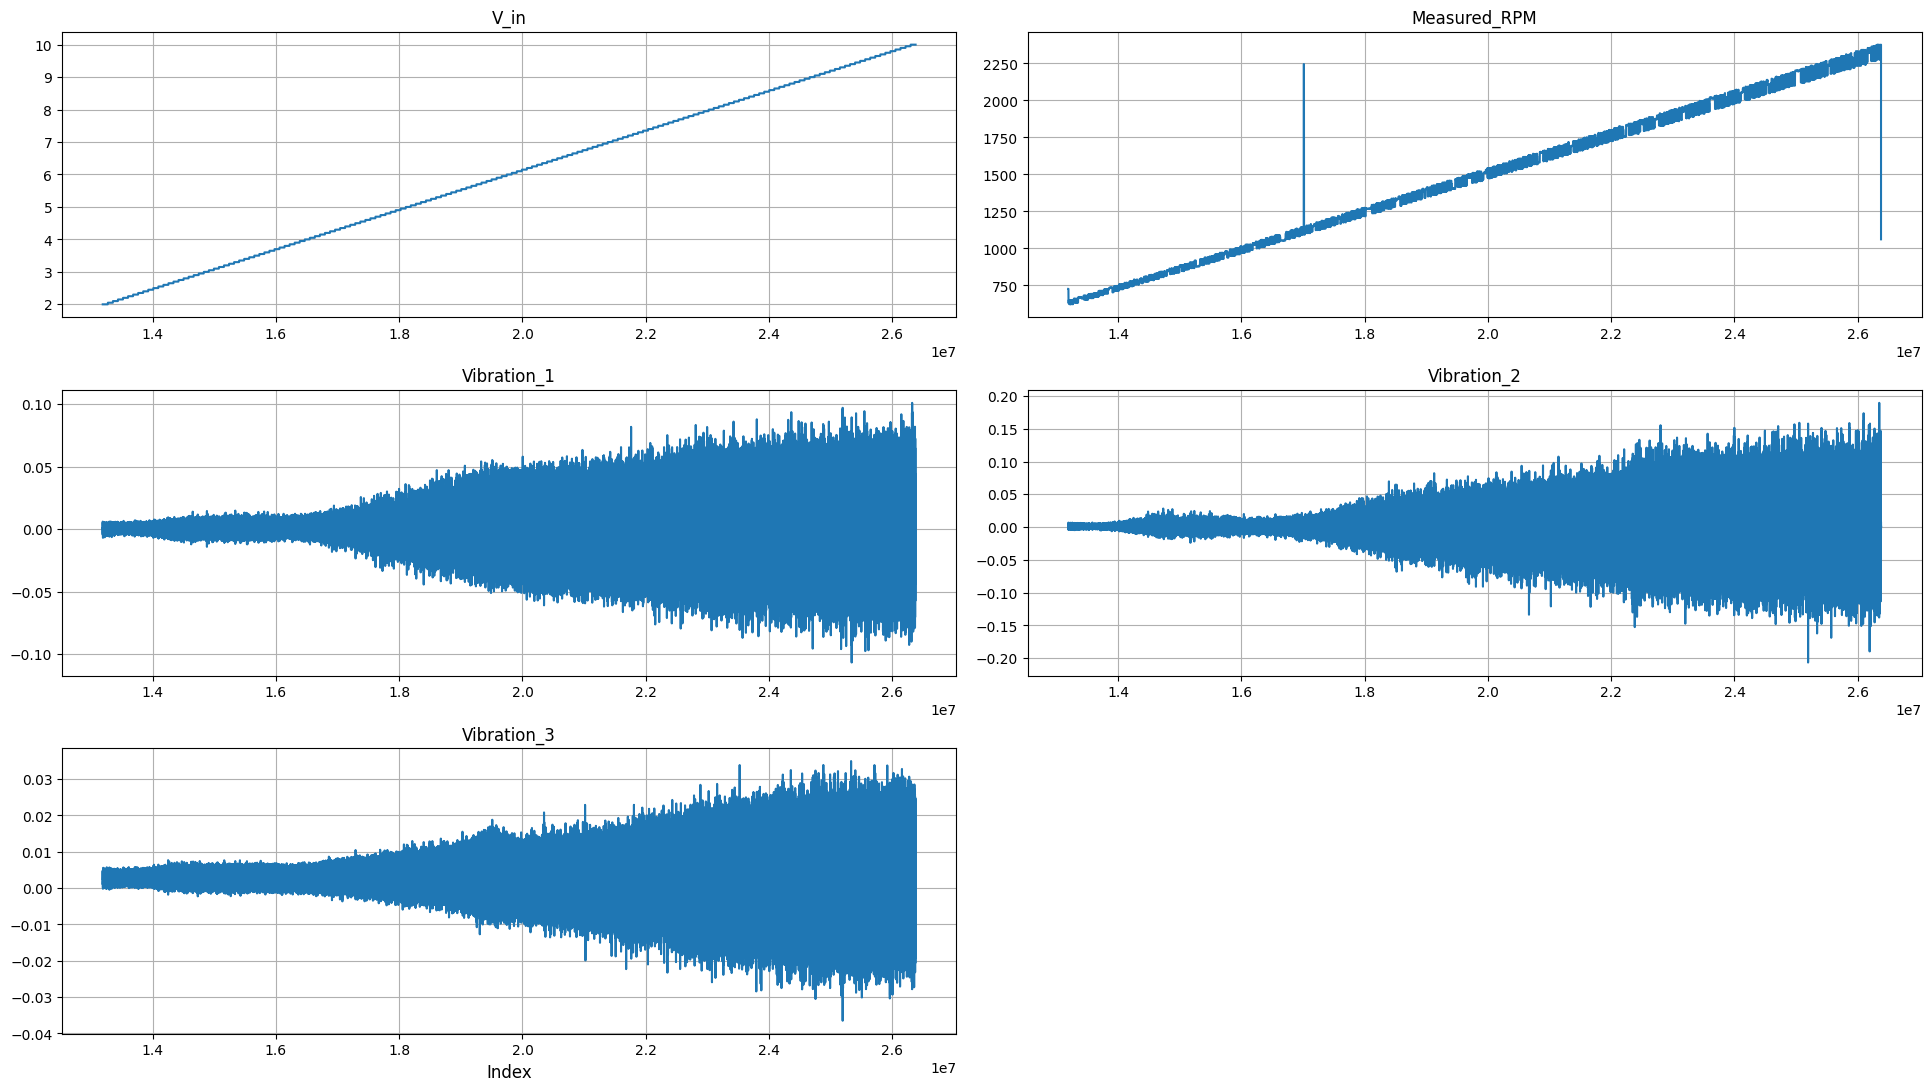

In [9]:
if not TESTING:

    # visualize one random dataset for data validation
    vis.plot_columns_as_subplots(all_datasets[CONTROL_INDEX],
                                 all_datasets[CONTROL_INDEX].columns)
    
else:
    
    # visualize the program testing set
    for measurement_cycle in test_measurement_cycles:
        vis.plot_columns_as_subplots(measurement_cycle, measurement_cycle.columns)

##### **Fast Fourier Transformation**
Eine Fast Fourier Transformation (FFT) über führt die Daten eines ausgewählten Sensors vom Zeit- in den Frequenzbereich. Sie verwendet ein Fenster von einer Sekunde bzw. $n=4096$ Messwerten. Mey et al. verwenden in ihrer Arbeit die ersten 2048 Fourier-Koeffizienten. Diese sind der *Zero Frequency Term* bei $0 \times f_s$, die Summe des Signals, und die 2047 positiven Frequenzanteile (*frequency components*). NumPy bietet zur Berechnung der positiven Frequenzanteile die *Real FFT* numpy.rfft(), die in diesem Projekt implementiert ist. Pro Sekunde des ursprünglichen Datensatzes generiert die FFT somit 2048 Frequenzanteile. Aufgrund der Halbierung der Anzahl von Messwerten, speichert ein neues Dataset die Fourier-Koeffizienten. 

$$A_k = \frac{1}{n} \cdot \sum^{n-1}_{m=0} a_m \cdot e^{-2\,\pi\,i\,\frac{m\,k}{n}} \qquad \text{mit} \qquad a_m = e^{2\,\pi\,i\,m\,f\,\Delta t} \quad \text{und} \quad k = 0,~\dots,~n-1$$

Für eine spätere Zuordnung wird mit derselben Fenstergröße der Median der Drehzahlen berechnet. Das Label des ursprünglichen Datensatzes wird in das neue Dataset übertragen.

In [ ]:
SENSOR: int = 1

if not TESTING:

    for index, dataset in enumerate(all_datasets):
        # calculate fft frequencies and magnitudes alongside the median rpms
        fft_dataset = pre.calculate_fft_magnitudes(dataset, column=f"Vibration_{SENSOR}", normalize=False)
        rpms = pre.median(dataset, column="Measured_RPM", stretch=True)
        fft_dataset["rpm"] = rpms[::2]
        all_datasets[index] = fft_dataset

else:
    
    for index, measurement_cycle in enumerate(test_measurement_cycles):
        fft_data = pre.calculate_fft_magnitudes(measurement_cycle, column=f"Vibration_{SENSOR}", normalize=False)
        rpms = pre.median(measurement_cycle, column="Measured_RPM", stretch=True)
        fft_data["rpm"] = rpms[::2]
        test_measurement_cycles[index] = fft_data

,fft_frequency,fft_magnitude,rpm
count,6.594560e+06,6.594560e+06,6.594560e+06
mean,1.024500e+03,2.708024e-01,1.480859e+03
std,5.912066e+02,4.985993e-01,4.928347e+02
min,1.000000e+00,4.391999e-10,6.184371e+02
25%,5.127500e+02,2.606276e-02,1.054234e+03
50%,1.024500e+03,8.541440e-02,1.484890e+03
75%,1.536250e+03,2.993170e-01,1.906070e+03
max,2.048000e+03,3.244788e+02,2.376542e+03


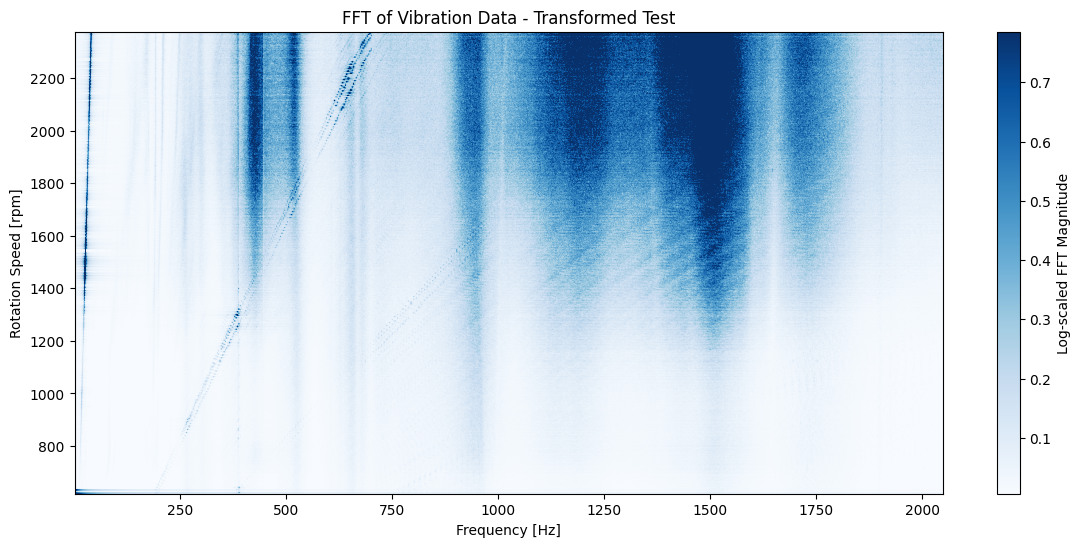

,fft_frequency,fft_magnitude,rpm
count,6.594560e+06,6.594560e+06,6.594560e+06
mean,1.024500e+03,2.760619e-01,1.483423e+03
std,5.912066e+02,4.652482e-01,4.934476e+02
min,1.000000e+00,3.576180e-06,6.221231e+02
25%,5.127500e+02,2.690271e-02,1.053316e+03
50%,1.024500e+03,8.755016e-02,1.485422e+03
75%,1.536250e+03,3.063466e-01,1.909418e+03
max,2.048000e+03,1.192775e+01,2.376676e+03


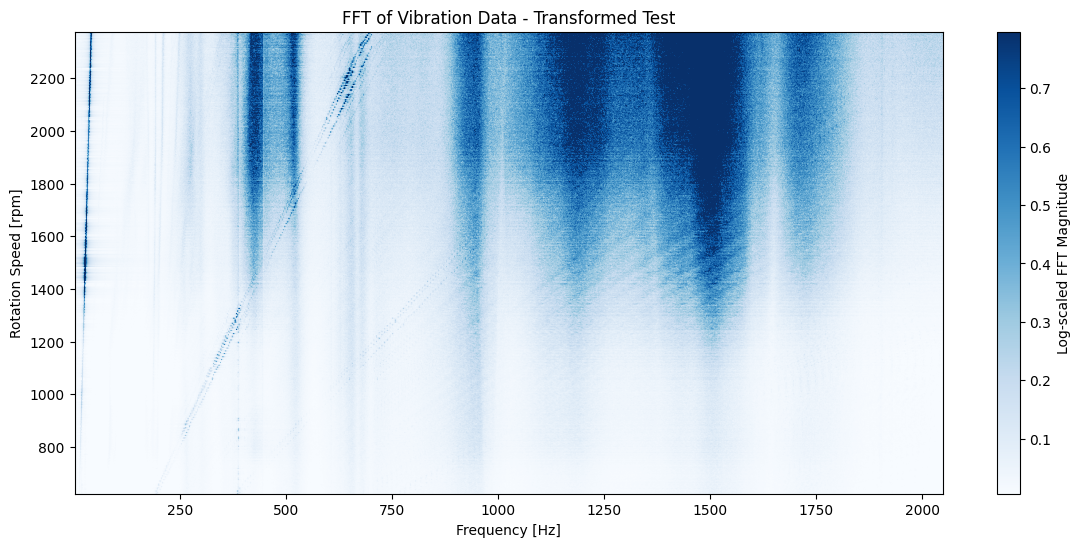

In [ ]:
if not TESTING:

    # describe one random dataset for data validation
    display(all_datasets[CONTROL_INDEX].describe())

else:
    
    # program testing set
    for measurement_cycle in test_measurement_cycles:
        display(measurement_cycle.describe())
        vis.plot_fft_spectrogram(data_frame=measurement_cycle,
                                 figsize=(14, 6))

##### **Robust Scaling**

Robust Scaling entfernt aus der Messreihe $X$ 

Interquantilabstand (*Inter-Quantile Range*, IRQ) zwischen dem 5%-Quantil $x_{0.05}$ und dem 95%-Quantil $x_{0.95}$.

$$x^*_i = \frac{x_i - \text{median}~{X}}{x_{0.95} - x_{0.05}} \qquad \text{mit} \qquad X=\{x_0,~x_1,~\dots,~x_n-1\}$$

In [38]:
if not TESTING:

    for index, dataset in enumerate(all_datasets):
        all_datasets[index] = pre.scale_robust(dataset, column="fft_magnitude")

else:
    for index, measurement_cycle in enumerate(test_measurement_cycles):
        scaled_data = pre.scale_robust(measurement_cycle, column="fft_magnitude")
        test_measurement_cycles[index] = scaled_data

,fft_frequency,fft_magnitude,rpm
count,6.594560e+06,6.594560e+06,6.594560e+06
mean,1.024500e+03,1.245281e-01,1.480859e+03
std,5.912066e+02,4.057641e-01,4.928347e+02
min,1.000000e+00,-2.841837e-01,6.184371e+02
25%,5.127500e+02,-1.140481e-01,1.054234e+03
50%,1.024500e+03,0.000000e+00,1.484890e+03
75%,1.536250e+03,2.358303e-01,1.906070e+03
max,2.048000e+03,1.112700e+02,2.376542e+03


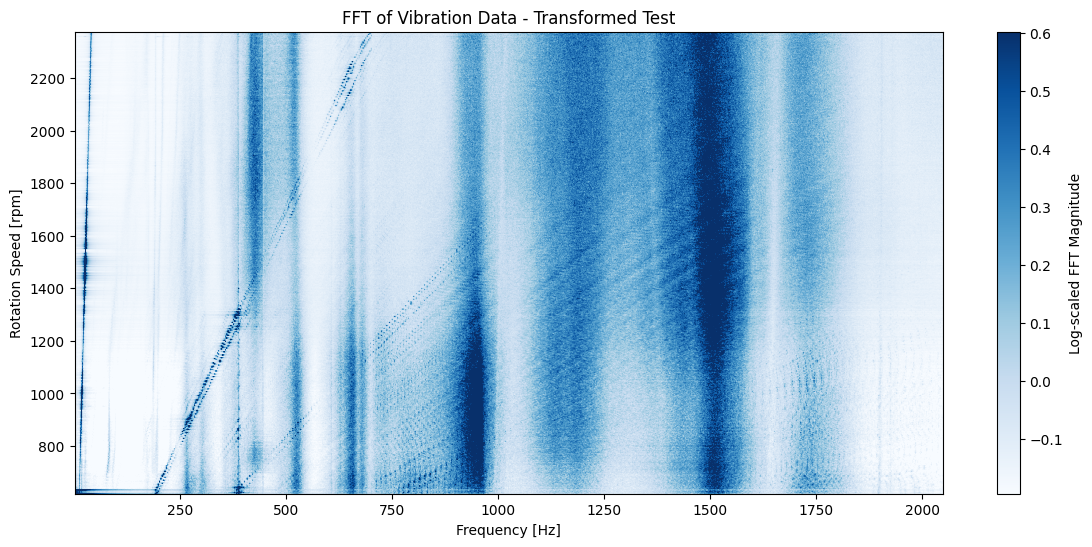

,fft_frequency,fft_magnitude,rpm
count,6.594560e+06,6.594560e+06,6.594560e+06
mean,1.024500e+03,1.241122e-01,1.483423e+03
std,5.912066e+02,3.661175e-01,4.934476e+02
min,1.000000e+00,-2.870545e-01,6.221231e+02
25%,5.127500e+02,-1.132673e-01,1.053316e+03
50%,1.024500e+03,-1.657093e-17,1.485422e+03
75%,1.536250e+03,2.369727e-01,1.909418e+03
max,2.048000e+03,2.355203e+01,2.376676e+03


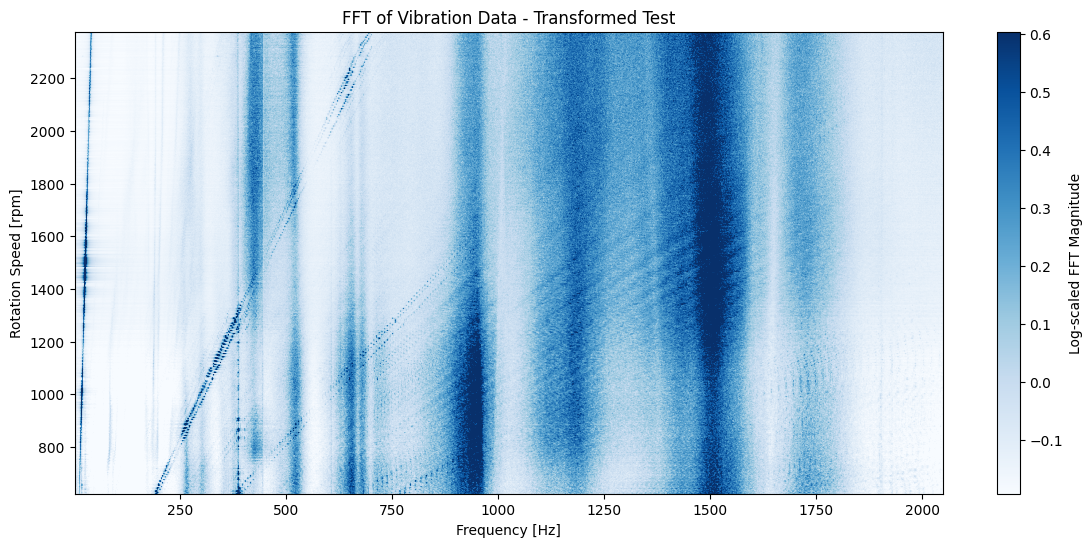

In [ ]:
if not TESTING:

    # describe one random dataset for data validation
    display(all_datasets[CONTROL_INDEX].describe())

else:
    
    # program testing set
    for measurement_cycle in test_measurement_cycles:
        display(measurement_cycle.describe())
        vis.plot_fft_spectrogram(data_frame=measurement_cycle,
                                 figsize=(14, 6))

In [14]:
# saving the preprocessed data
if not TESTING:

    for dataset in all_datasets:
        dl.save_dataset(dataset, uuid=UUID)

else:
    dl.save_dataset(transformed_test, uuid=UUID)

0D.csv successfully saved.
1D.csv successfully saved.
2D.csv successfully saved.
3D.csv successfully saved.
4D.csv successfully saved.
0E.csv successfully saved.
1E.csv successfully saved.
2E.csv successfully saved.
3E.csv successfully saved.
4E.csv successfully saved.
